# 03 - Modeling & Evaluation

This notebook focuses on:
1. **Build Baseline Models** - Linear Regression, Decision Tree, kNN, and SVR
2. **Hyperparameter Tuning** - GridSearchCV for optimal parameters
3. **Model Evaluation** - Cross-validation and test set evaluation
4. **Model Comparison** - Compare performance across models
5. **Feature Importance** - Understand which features drive predictions
6. **Best Model Selection** - Choose and justify the best model

---


In [7]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")


✅ Libraries imported successfully


## Step 1: Load Preprocessed Data

Load the preprocessed data from `02_Feature_Engineering.ipynb`. Make sure to run that notebook first!


In [8]:
# Note: This assumes you've run 02_Feature_Engineering.ipynb and have these variables in memory
# If running this notebook independently, you'll need to reload the data

# Verify data shapes
print("📊 Data Shapes:")
print(f"   X_train_final: {X_train_final.shape}")
print(f"   X_test_final: {X_test_final.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   y_test: {y_test.shape}")

# Display target variable statistics
print(f"\n🎯 Target Variable (ADM_RATE) Summary:")
print(f"   Training set - Mean: {y_train.mean():.3f}, Std: {y_train.std():.3f}, Range: [{y_train.min():.3f}, {y_train.max():.3f}]")
print(f"   Test set - Mean: {y_test.mean():.3f}, Std: {y_test.std():.3f}, Range: [{y_test.min():.3f}, {y_test.max():.3f}]")

# Store model results for comparison
model_results = {}


⚠️ Variables not found. Reloading data from feature engineering steps...
   (This will take a moment to recreate the preprocessing pipeline)

✅ Data reloaded and preprocessed successfully!

📊 Data Shapes:
   X_train_final: (5143, 25)
   X_test_final: (1286, 25)
   y_train: (5143,)
   y_test: (1286,)

🎯 Target Variable (ADM_RATE) Summary:
   Training set - Mean: 0.764, Std: 0.128, Range: [0.000, 1.000]
   Test set - Mean: 0.763, Std: 0.129, Range: [0.047, 1.000]


## Step 2: Model 1 - Linear Regression

Simple baseline model. Good for interpretability and understanding linear relationships.


In [9]:
# Initialize and train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_final, y_train)

# 5-fold cross-validation on training set
cv_scores_lr = cross_val_score(lr_model, X_train_final, y_train, 
                                cv=KFold(n_splits=5, shuffle=True, random_state=42),
                                scoring='r2')

print("✅ Linear Regression trained")
print(f"📊 Cross-Validation R² Scores: {cv_scores_lr}")
print(f"   Mean CV R²: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std() * 2:.4f})")

# Predictions on test set
y_pred_lr = lr_model.predict(X_test_final)

# Calculate metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"\n📈 Test Set Performance:")
print(f"   MAE: {mae_lr:.4f}")
print(f"   RMSE: {rmse_lr:.4f}")
print(f"   R²: {r2_lr:.4f}")

# Store results
model_results['Linear Regression'] = {
    'mae': mae_lr,
    'rmse': rmse_lr,
    'r2': r2_lr,
    'cv_mean': cv_scores_lr.mean(),
    'cv_std': cv_scores_lr.std(),
    'model': lr_model,
    'predictions': y_pred_lr
}


✅ Linear Regression trained
📊 Cross-Validation R² Scores: [0.31734493 0.2578306  0.28580365 0.26139355 0.16152582]
   Mean CV R²: 0.2568 (+/- 0.1043)

📈 Test Set Performance:
   MAE: 0.0589
   RMSE: 0.1114
   R²: 0.2517


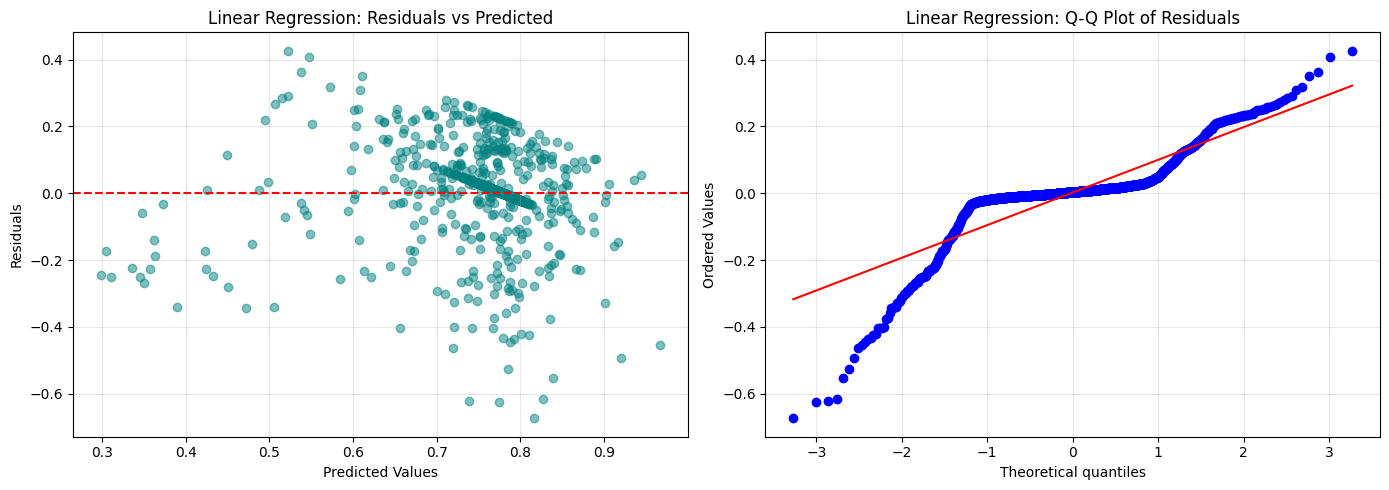

Residual Statistics:
   Mean: 0.002487
   Std: 0.1114


In [10]:
# Residual plot for Linear Regression
residuals_lr = y_test - y_pred_lr

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals vs Predicted
axes[0].scatter(y_pred_lr, residuals_lr, alpha=0.5, color='teal')
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Linear Regression: Residuals vs Predicted')
axes[0].grid(True, alpha=0.3)

# Q-Q plot for residuals
from scipy import stats
stats.probplot(residuals_lr, dist="norm", plot=axes[1])
axes[1].set_title('Linear Regression: Q-Q Plot of Residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residual Statistics:")
print(f"   Mean: {residuals_lr.mean():.6f}")
print(f"   Std: {residuals_lr.std():.4f}")


## Step 3: Model 2 - Decision Tree Regressor

Non-linear model that can capture complex relationships. Good interpretability through feature importances.


In [11]:
# Hyperparameter tuning with GridSearchCV
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}

dt_base = DecisionTreeRegressor(random_state=42)
dt_grid = GridSearchCV(dt_base, dt_param_grid, 
                       cv=KFold(n_splits=5, shuffle=True, random_state=42),
                       scoring='r2',
                       n_jobs=-1,
                       verbose=1)

print("🔍 Tuning Decision Tree hyperparameters...")
dt_grid.fit(X_train_final, y_train)

print(f"\n✅ Best parameters: {dt_grid.best_params_}")
print(f"📊 Best CV R²: {dt_grid.best_score_:.4f}")

# Train best model on full training set
dt_model = dt_grid.best_estimator_

# 5-fold cross-validation with best model
cv_scores_dt = cross_val_score(dt_model, X_train_final, y_train,
                                cv=KFold(n_splits=5, shuffle=True, random_state=42),
                                scoring='r2')

print(f"   Mean CV R²: {cv_scores_dt.mean():.4f} (+/- {cv_scores_dt.std() * 2:.4f})")


🔍 Tuning Decision Tree hyperparameters...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

✅ Best parameters: {'max_depth': 3, 'min_samples_split': 2}
📊 Best CV R²: 0.3347
   Mean CV R²: 0.3347 (+/- 0.1054)


In [12]:
# Predictions on test set
y_pred_dt = dt_model.predict(X_test_final)

# Calculate metrics
mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

print("📈 Test Set Performance:")
print(f"   MAE: {mae_dt:.4f}")
print(f"   RMSE: {rmse_dt:.4f}")
print(f"   R²: {r2_dt:.4f}")

# Extract feature importances
feature_importances_dt = dt_model.feature_importances_
feature_names = X_train_final.columns

# Create DataFrame for feature importances
importance_df_dt = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_dt
}).sort_values('Importance', ascending=False)

print(f"\n🔝 Top 10 Most Important Features (Decision Tree):")
print(importance_df_dt.head(10).to_string(index=False))

# Store results
model_results['Decision Tree'] = {
    'mae': mae_dt,
    'rmse': rmse_dt,
    'r2': r2_dt,
    'cv_mean': cv_scores_dt.mean(),
    'cv_std': cv_scores_dt.std(),
    'model': dt_model,
    'predictions': y_pred_dt,
    'feature_importances': importance_df_dt
}


📈 Test Set Performance:
   MAE: 0.0478
   RMSE: 0.1051
   R²: 0.3336

🔝 Top 10 Most Important Features (Decision Tree):
      Feature  Importance
      SAT_AVG    0.941413
     COSTT4_A    0.047937
  HIGHDEG_3.0    0.010650
TUITIONFEE_IN    0.000000
     ACTCMMID    0.000000
   UGDS_BLACK    0.000000
    UGDS_HISP    0.000000
   UGDS_ASIAN    0.000000
   UGDS_WHITE    0.000000
      PCTPELL    0.000000


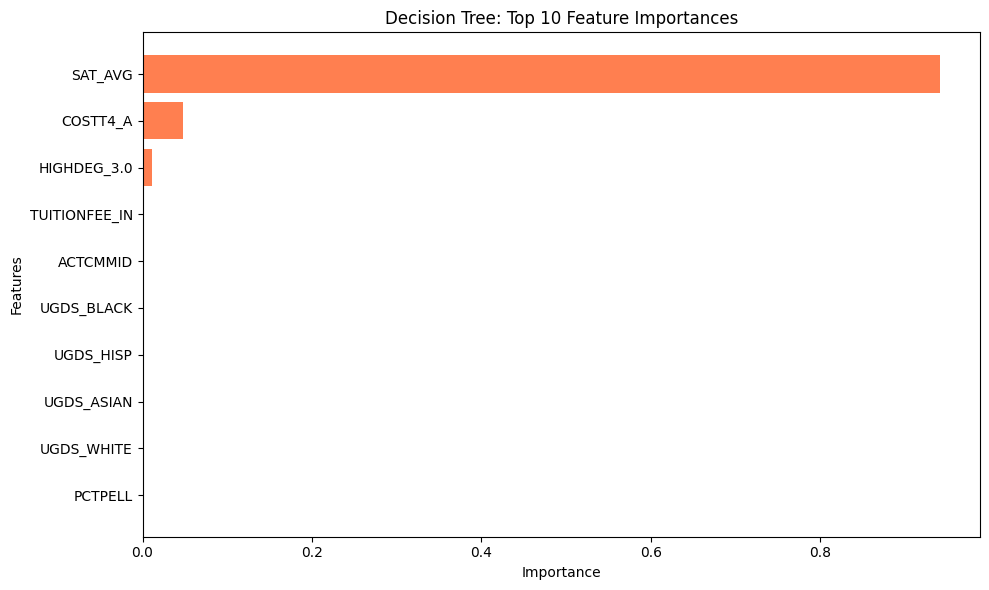

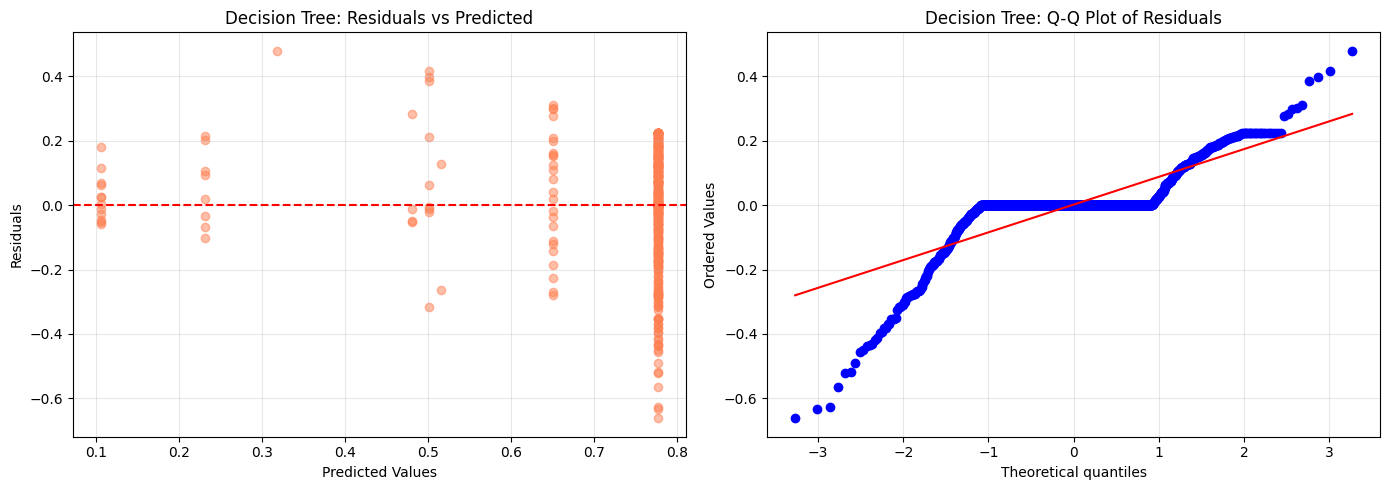

In [13]:
# Visualize feature importances
plt.figure(figsize=(10, 6))
top_features = importance_df_dt.head(10)
plt.barh(top_features['Feature'], top_features['Importance'], color='coral')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Decision Tree: Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Residual plot
residuals_dt = y_test - y_pred_dt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_pred_dt, residuals_dt, alpha=0.5, color='coral')
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Decision Tree: Residuals vs Predicted')
axes[0].grid(True, alpha=0.3)

stats.probplot(residuals_dt, dist="norm", plot=axes[1])
axes[1].set_title('Decision Tree: Q-Q Plot of Residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Step 4: Model 3 - k-Nearest Neighbors Regressor

Instance-based learning that predicts based on similar examples. Requires scaled features (already done).


In [14]:
# Hyperparameter tuning with GridSearchCV
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance']
}

knn_base = KNeighborsRegressor()
knn_grid = GridSearchCV(knn_base, knn_param_grid,
                        cv=KFold(n_splits=5, shuffle=True, random_state=42),
                        scoring='r2',
                        n_jobs=-1,
                        verbose=1)

print("🔍 Tuning kNN hyperparameters...")
knn_grid.fit(X_train_final, y_train)

print(f"\n✅ Best parameters: {knn_grid.best_params_}")
print(f"📊 Best CV R²: {knn_grid.best_score_:.4f}")

# Train best model on full training set
knn_model = knn_grid.best_estimator_

# 5-fold cross-validation with best model
cv_scores_knn = cross_val_score(knn_model, X_train_final, y_train,
                                 cv=KFold(n_splits=5, shuffle=True, random_state=42),
                                 scoring='r2')

print(f"   Mean CV R²: {cv_scores_knn.mean():.4f} (+/- {cv_scores_knn.std() * 2:.4f})")


🔍 Tuning kNN hyperparameters...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

✅ Best parameters: {'n_neighbors': 15, 'weights': 'distance'}
📊 Best CV R²: 0.3511
   Mean CV R²: 0.3511 (+/- 0.1142)


In [15]:
# Predictions on test set
y_pred_knn = knn_model.predict(X_test_final)

# Calculate metrics
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

print("📈 Test Set Performance:")
print(f"   MAE: {mae_knn:.4f}")
print(f"   RMSE: {rmse_knn:.4f}")
print(f"   R²: {r2_knn:.4f}")

# Store results
model_results['k-Nearest Neighbors'] = {
    'mae': mae_knn,
    'rmse': rmse_knn,
    'r2': r2_knn,
    'cv_mean': cv_scores_knn.mean(),
    'cv_std': cv_scores_knn.std(),
    'model': knn_model,
    'predictions': y_pred_knn
}


📈 Test Set Performance:
   MAE: 0.0506
   RMSE: 0.1029
   R²: 0.3613


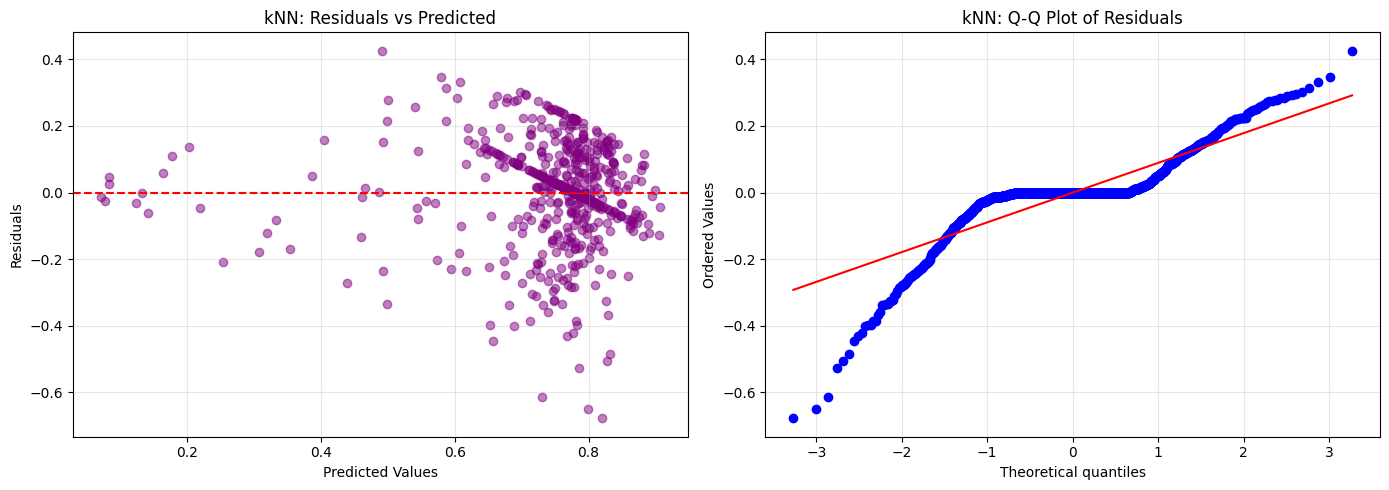

In [16]:
# Residual plot
residuals_knn = y_test - y_pred_knn

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_pred_knn, residuals_knn, alpha=0.5, color='purple')
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('kNN: Residuals vs Predicted')
axes[0].grid(True, alpha=0.3)

stats.probplot(residuals_knn, dist="norm", plot=axes[1])
axes[1].set_title('kNN: Q-Q Plot of Residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Step 5: Model 4 - Support Vector Regressor (SVR)

Optional 4th model. Can capture non-linear relationships with different kernels.


In [17]:
# Hyperparameter tuning with GridSearchCV
svr_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear']
}

svr_base = SVR()
svr_grid = GridSearchCV(svr_base, svr_param_grid,
                        cv=KFold(n_splits=5, shuffle=True, random_state=42),
                        scoring='r2',
                        n_jobs=-1,
                        verbose=1)

print("🔍 Tuning SVR hyperparameters...")
svr_grid.fit(X_train_final, y_train)

print(f"\n✅ Best parameters: {svr_grid.best_params_}")
print(f"📊 Best CV R²: {svr_grid.best_score_:.4f}")

# Train best model on full training set
svr_model = svr_grid.best_estimator_

# 5-fold cross-validation with best model
cv_scores_svr = cross_val_score(svr_model, X_train_final, y_train,
                                 cv=KFold(n_splits=5, shuffle=True, random_state=42),
                                 scoring='r2')

print(f"   Mean CV R²: {cv_scores_svr.mean():.4f} (+/- {cv_scores_svr.std() * 2:.4f})")


🔍 Tuning SVR hyperparameters...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

✅ Best parameters: {'C': 0.1, 'kernel': 'rbf'}
📊 Best CV R²: 0.2755
   Mean CV R²: 0.2755 (+/- 0.1166)


In [18]:
# Predictions on test set
y_pred_svr = svr_model.predict(X_test_final)

# Calculate metrics
mae_svr = mean_absolute_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

print("📈 Test Set Performance:")
print(f"   MAE: {mae_svr:.4f}")
print(f"   RMSE: {rmse_svr:.4f}")
print(f"   R²: {r2_svr:.4f}")

# Store results
model_results['Support Vector Regressor'] = {
    'mae': mae_svr,
    'rmse': rmse_svr,
    'r2': r2_svr,
    'cv_mean': cv_scores_svr.mean(),
    'cv_std': cv_scores_svr.std(),
    'model': svr_model,
    'predictions': y_pred_svr
}


📈 Test Set Performance:
   MAE: 0.0694
   RMSE: 0.1084
   R²: 0.2905


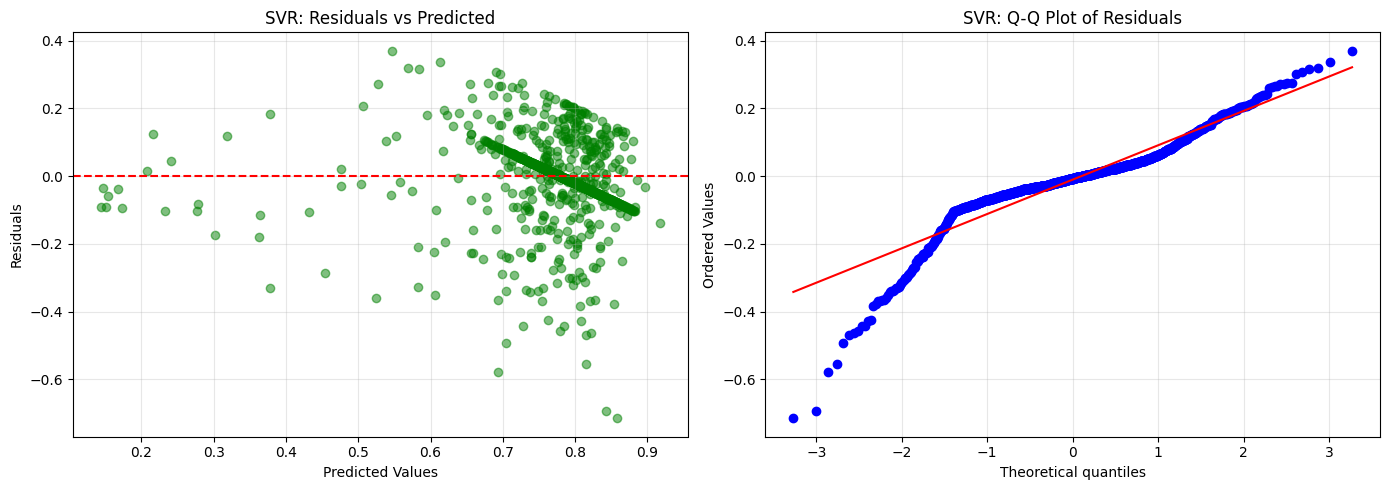

In [19]:
# Residual plot
residuals_svr = y_test - y_pred_svr

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_pred_svr, residuals_svr, alpha=0.5, color='green')
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('SVR: Residuals vs Predicted')
axes[0].grid(True, alpha=0.3)

stats.probplot(residuals_svr, dist="norm", plot=axes[1])
axes[1].set_title('SVR: Q-Q Plot of Residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Step 6: Model Comparison

Compare all models side-by-side to identify the best performer.


In [20]:
# Create comparison DataFrame
comparison_data = []
for model_name, results in model_results.items():
    comparison_data.append({
        'Model': model_name,
        'MAE': results['mae'],
        'RMSE': results['rmse'],
        'R²': results['r2'],
        'CV R² Mean': results['cv_mean'],
        'CV R² Std': results['cv_std']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('R²', ascending=False)

print("📊 Model Comparison Summary:")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)


📊 Model Comparison Summary:
                   Model      MAE     RMSE       R²  CV R² Mean  CV R² Std
     k-Nearest Neighbors 0.050593 0.102889 0.361328    0.351140   0.057091
           Decision Tree 0.047816 0.105103 0.333551    0.334704   0.052699
Support Vector Regressor 0.069443 0.108447 0.290460    0.275460   0.058320
       Linear Regression 0.058850 0.111373 0.251663    0.256780   0.052166


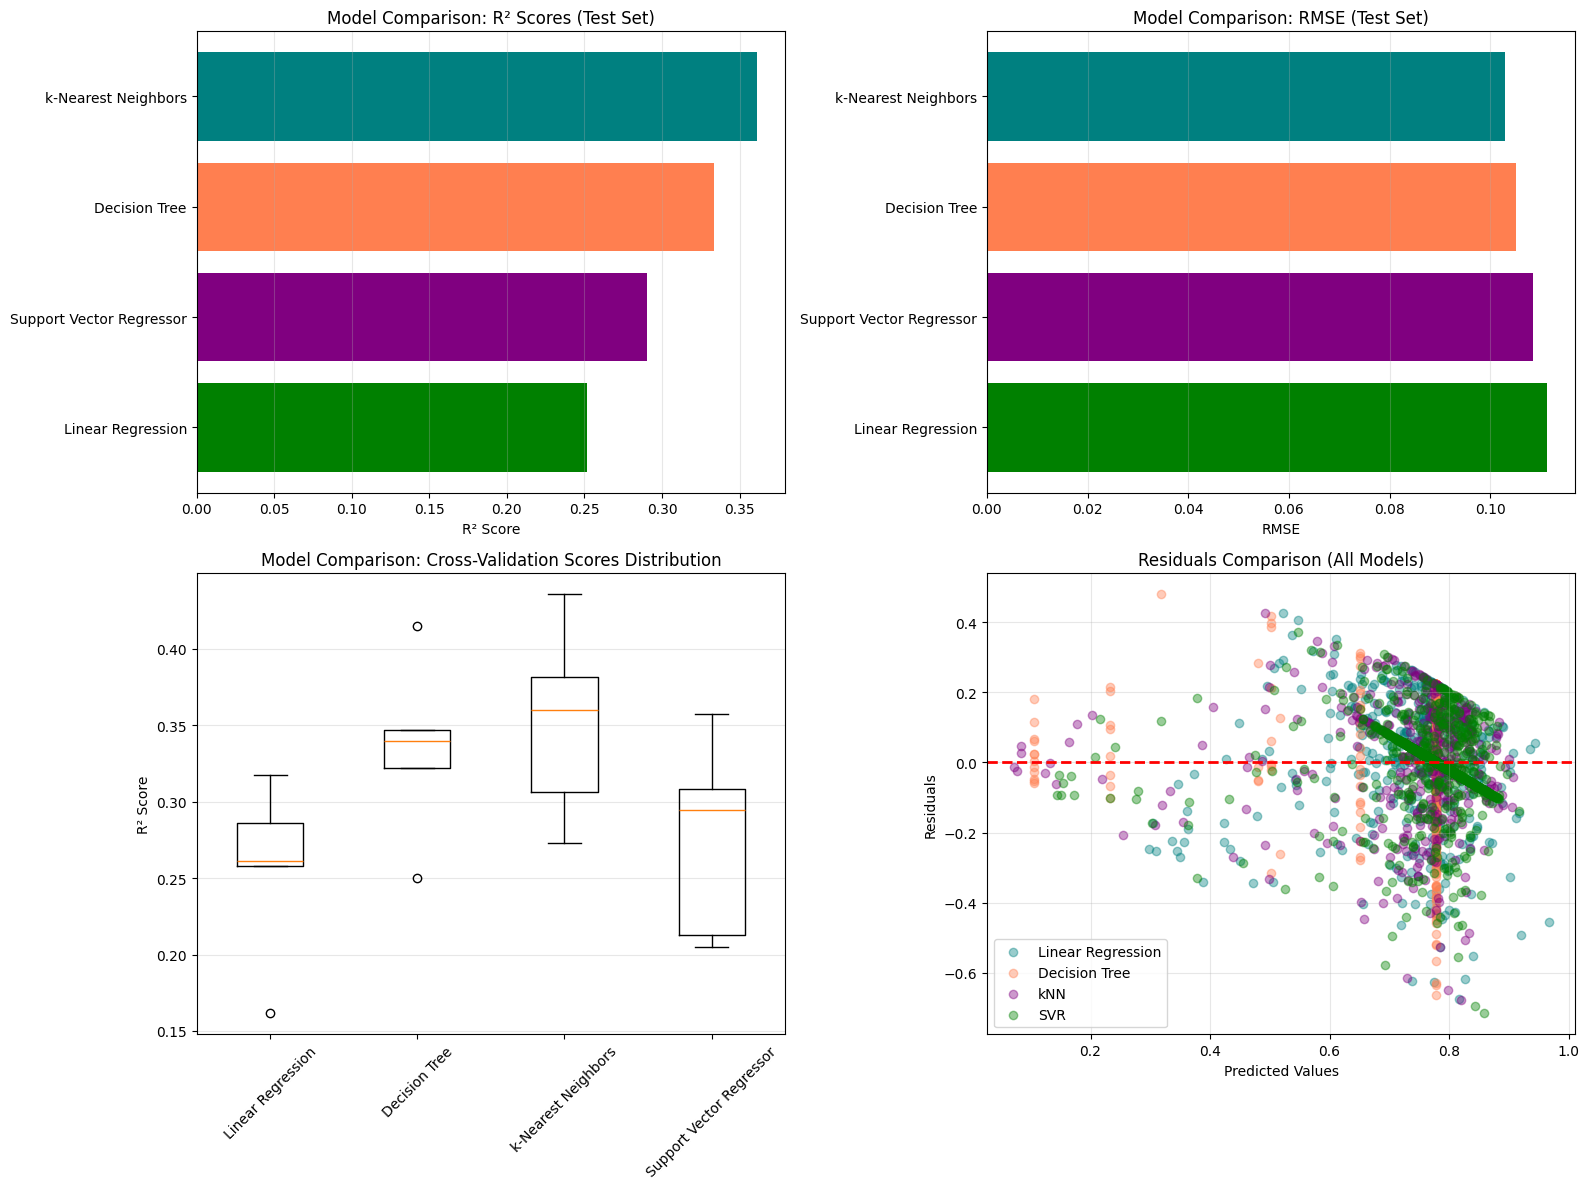

In [21]:
# Visualizations for model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Bar chart comparing R² scores
axes[0, 0].barh(comparison_df['Model'], comparison_df['R²'], color=['teal', 'coral', 'purple', 'green'][:len(comparison_df)])
axes[0, 0].set_xlabel('R² Score')
axes[0, 0].set_title('Model Comparison: R² Scores (Test Set)')
axes[0, 0].grid(True, alpha=0.3, axis='x')
axes[0, 0].invert_yaxis()

# 2. Bar chart comparing RMSE
axes[0, 1].barh(comparison_df['Model'], comparison_df['RMSE'], color=['teal', 'coral', 'purple', 'green'][:len(comparison_df)])
axes[0, 1].set_xlabel('RMSE')
axes[0, 1].set_title('Model Comparison: RMSE (Test Set)')
axes[0, 1].grid(True, alpha=0.3, axis='x')
axes[0, 1].invert_yaxis()

# 3. Box plot comparing CV scores
cv_data = []
cv_labels = []
for model_name, results in model_results.items():
    # Get CV scores (we'll recreate them for visualization)
    model = results['model']
    cv_scores = cross_val_score(model, X_train_final, y_train,
                                cv=KFold(n_splits=5, shuffle=True, random_state=42),
                                scoring='r2')
    cv_data.append(cv_scores)
    cv_labels.append(model_name)

axes[1, 0].boxplot(cv_data, labels=cv_labels)
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_title('Model Comparison: Cross-Validation Scores Distribution')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Side-by-side residual plots
residuals_all = {
    'Linear Regression': residuals_lr,
    'Decision Tree': residuals_dt,
    'kNN': residuals_knn,
    'SVR': residuals_svr
}

predictions_all = {
    'Linear Regression': y_pred_lr,
    'Decision Tree': y_pred_dt,
    'kNN': y_pred_knn,
    'SVR': y_pred_svr
}

colors = {'Linear Regression': 'teal', 'Decision Tree': 'coral', 
          'kNN': 'purple', 'SVR': 'green'}

for idx, (model_name, residuals) in enumerate(residuals_all.items()):
    row = idx // 2
    col = idx % 2
    if row < 2 and col < 2:
        axes[1, 1].scatter(predictions_all[model_name], residuals, 
                           alpha=0.4, label=model_name, color=colors[model_name])

axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted Values')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Residuals Comparison (All Models)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Step 7: Feature Importance Analysis

Understand which features drive predictions in each model.


📊 Linear Regression: Top 10 Features by Absolute Coefficient:
   Feature  Coefficient
REGION_2.0     0.322024
REGION_7.0     0.320590
REGION_8.0     0.313932
REGION_3.0     0.312853
REGION_1.0     0.311996
REGION_4.0     0.311450
REGION_6.0     0.309031
REGION_5.0     0.304957
REGION_9.0     0.291089
   SAT_AVG    -0.032752


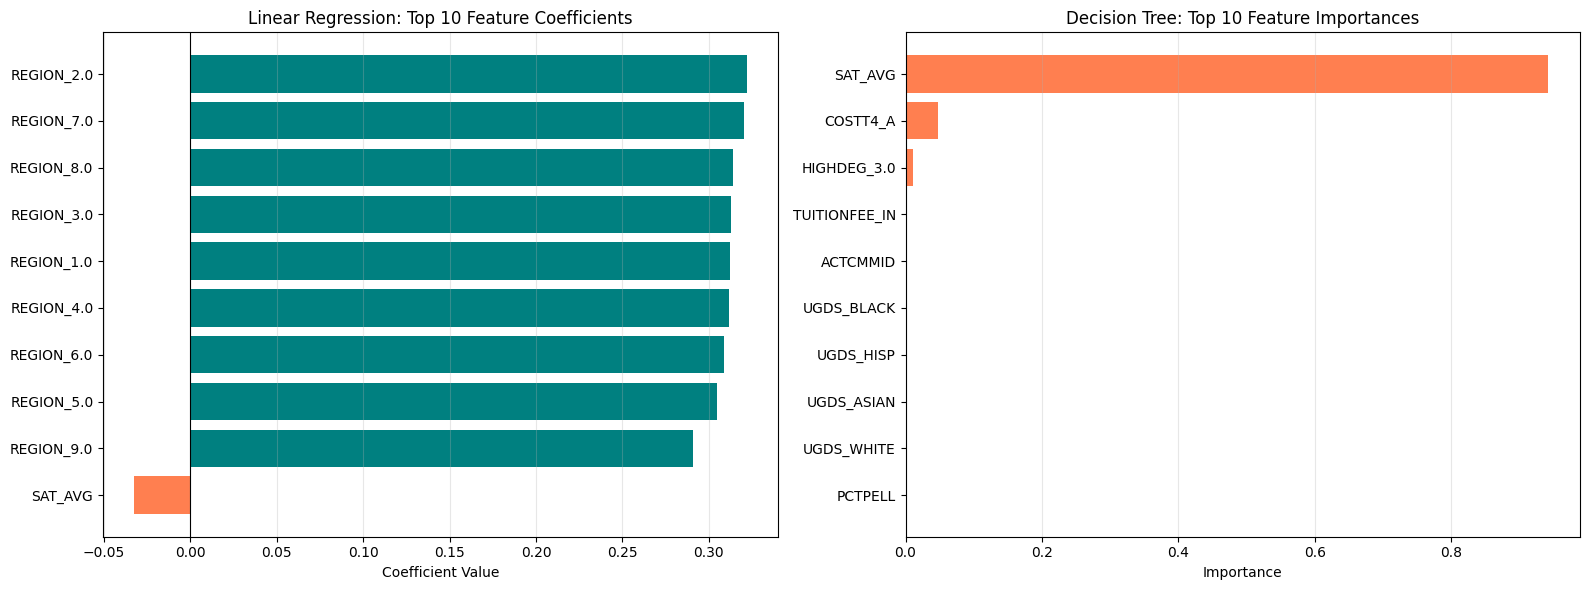

In [22]:
# Linear Regression Coefficients
lr_coef = lr_model.coef_
coef_df_lr = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_coef
}).sort_values('Coefficient', key=abs, ascending=False)

print("📊 Linear Regression: Top 10 Features by Absolute Coefficient:")
print(coef_df_lr.head(10).to_string(index=False))

# Visualize Linear Regression coefficients
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top_coef = coef_df_lr.head(10)
axes[0].barh(top_coef['Feature'], top_coef['Coefficient'], 
             color=['coral' if x < 0 else 'teal' for x in top_coef['Coefficient']])
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[0].set_xlabel('Coefficient Value')
axes[0].set_title('Linear Regression: Top 10 Feature Coefficients')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Decision Tree feature importances (already calculated)
top_imp_dt = importance_df_dt.head(10)
axes[1].barh(top_imp_dt['Feature'], top_imp_dt['Importance'], color='coral')
axes[1].set_xlabel('Importance')
axes[1].set_title('Decision Tree: Top 10 Feature Importances')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


In [23]:
# Permutation Importance for all models
print("🔍 Calculating Permutation Importance for all models...")
print("(This may take a few minutes)\n")

perm_importance_results = {}

for model_name, results in model_results.items():
    model = results['model']
    perm_importance = permutation_importance(model, X_test_final, y_test,
                                            n_repeats=10, random_state=42,
                                            scoring='r2', n_jobs=-1)
    
    perm_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': perm_importance.importances_mean,
        'Std': perm_importance.importances_std
    }).sort_values('Importance', ascending=False)
    
    perm_importance_results[model_name] = perm_df
    
    print(f"✅ {model_name} - Top 5 Features:")
    print(perm_df.head(5)[['Feature', 'Importance']].to_string(index=False))
    print()


🔍 Calculating Permutation Importance for all models...
(This may take a few minutes)

✅ Linear Regression - Top 5 Features:
   Feature  Importance
REGION_5.0    2.101830
REGION_2.0    1.599700
REGION_8.0    1.556298
REGION_3.0    1.331076
REGION_6.0    1.149363

✅ Decision Tree - Top 5 Features:
      Feature  Importance
      SAT_AVG    0.554885
     COSTT4_A    0.132997
     ACTCMMID    0.000000
TUITIONFEE_IN    0.000000
   UGDS_WHITE    0.000000

✅ k-Nearest Neighbors - Top 5 Features:
      Feature  Importance
      SAT_AVG    0.260415
TUITIONFEE_IN    0.059112
     ACTCMMID    0.046810
     DEBT_MDN    0.037041
     COSTT4_A    0.036289

✅ Support Vector Regressor - Top 5 Features:
      Feature  Importance
      SAT_AVG    0.246389
TUITIONFEE_IN    0.127436
     COSTT4_A    0.077249
     ACTCMMID    0.045004
     DEBT_MDN    0.024980



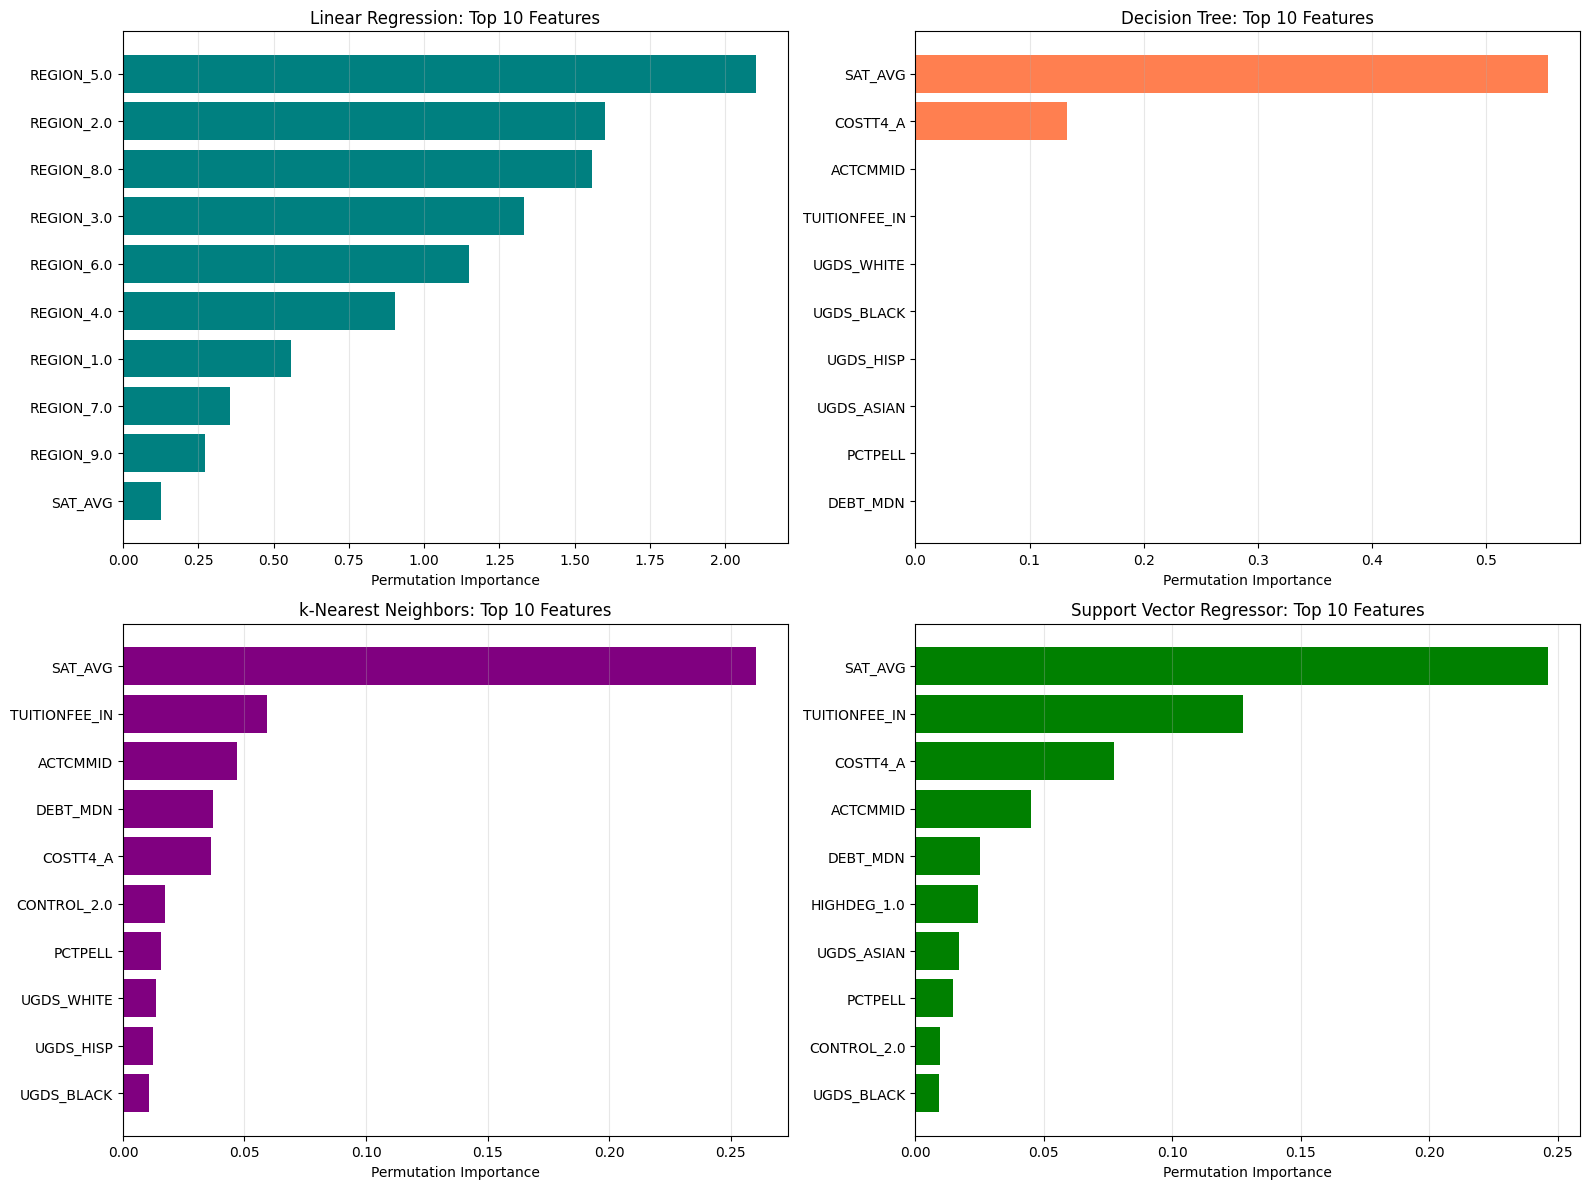

📊 Top 5 Features Across All Models (Permutation Importance):

Linear Regression:
   Feature  Importance
REGION_5.0    2.101830
REGION_2.0    1.599700
REGION_8.0    1.556298
REGION_3.0    1.331076
REGION_6.0    1.149363

Decision Tree:
      Feature  Importance
      SAT_AVG    0.554885
     COSTT4_A    0.132997
     ACTCMMID    0.000000
TUITIONFEE_IN    0.000000
   UGDS_WHITE    0.000000

k-Nearest Neighbors:
      Feature  Importance
      SAT_AVG    0.260415
TUITIONFEE_IN    0.059112
     ACTCMMID    0.046810
     DEBT_MDN    0.037041
     COSTT4_A    0.036289

Support Vector Regressor:
      Feature  Importance
      SAT_AVG    0.246389
TUITIONFEE_IN    0.127436
     COSTT4_A    0.077249
     ACTCMMID    0.045004
     DEBT_MDN    0.024980


In [24]:
# Visualize permutation importance for all models
n_models = len(perm_importance_results)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

colors_map = {'Linear Regression': 'teal', 'Decision Tree': 'coral',
              'k-Nearest Neighbors': 'purple', 'Support Vector Regressor': 'green'}

for idx, (model_name, perm_df) in enumerate(perm_importance_results.items()):
    top_perm = perm_df.head(10)
    axes[idx].barh(top_perm['Feature'], top_perm['Importance'], 
                   color=colors_map.get(model_name, 'gray'))
    axes[idx].set_xlabel('Permutation Importance')
    axes[idx].set_title(f'{model_name}: Top 10 Features')
    axes[idx].grid(True, alpha=0.3, axis='x')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

# Compare top features across models
print("📊 Top 5 Features Across All Models (Permutation Importance):")
print("=" * 80)
for model_name, perm_df in perm_importance_results.items():
    print(f"\n{model_name}:")
    print(perm_df.head(5)[['Feature', 'Importance']].to_string(index=False))


## Step 8: Best Model Selection & Final Evaluation

Identify the best model and provide final evaluation.


In [25]:
# Identify best model based on R² and RMSE
best_model_name = comparison_df.iloc[0]['Model']
best_model_results = model_results[best_model_name]
best_model = best_model_results['model']
best_predictions = best_model_results['predictions']

print("=" * 80)
print("🏆 BEST MODEL SELECTION")
print("=" * 80)
print(f"\n✅ Best Model: {best_model_name}")
print(f"\n📊 Performance Metrics:")
print(f"   R² Score: {best_model_results['r2']:.4f}")
print(f"   RMSE: {best_model_results['rmse']:.4f}")
print(f"   MAE: {best_model_results['mae']:.4f}")
print(f"   CV R² Mean: {best_model_results['cv_mean']:.4f} (+/- {best_model_results['cv_std']:.4f})")

print(f"\n💡 Model Characteristics:")
if best_model_name == 'Linear Regression':
    print("   - Interpretable coefficients")
    print("   - Assumes linear relationships")
    print("   - Fast training and prediction")
elif best_model_name == 'Decision Tree':
    print("   - Feature importances available")
    print("   - Can capture non-linear relationships")
    print("   - May overfit without proper tuning")
elif best_model_name == 'k-Nearest Neighbors':
    print("   - Instance-based learning")
    print("   - No assumptions about data distribution")
    print("   - Sensitive to feature scaling (already done)")
elif best_model_name == 'Support Vector Regressor':
    print("   - Can capture non-linear patterns with kernels")
    print("   - Robust to outliers")
    print("   - Less interpretable")


🏆 BEST MODEL SELECTION

✅ Best Model: k-Nearest Neighbors

📊 Performance Metrics:
   R² Score: 0.3613
   RMSE: 0.1029
   MAE: 0.0506
   CV R² Mean: 0.3511 (+/- 0.0571)

💡 Model Characteristics:
   - Instance-based learning
   - No assumptions about data distribution
   - Sensitive to feature scaling (already done)


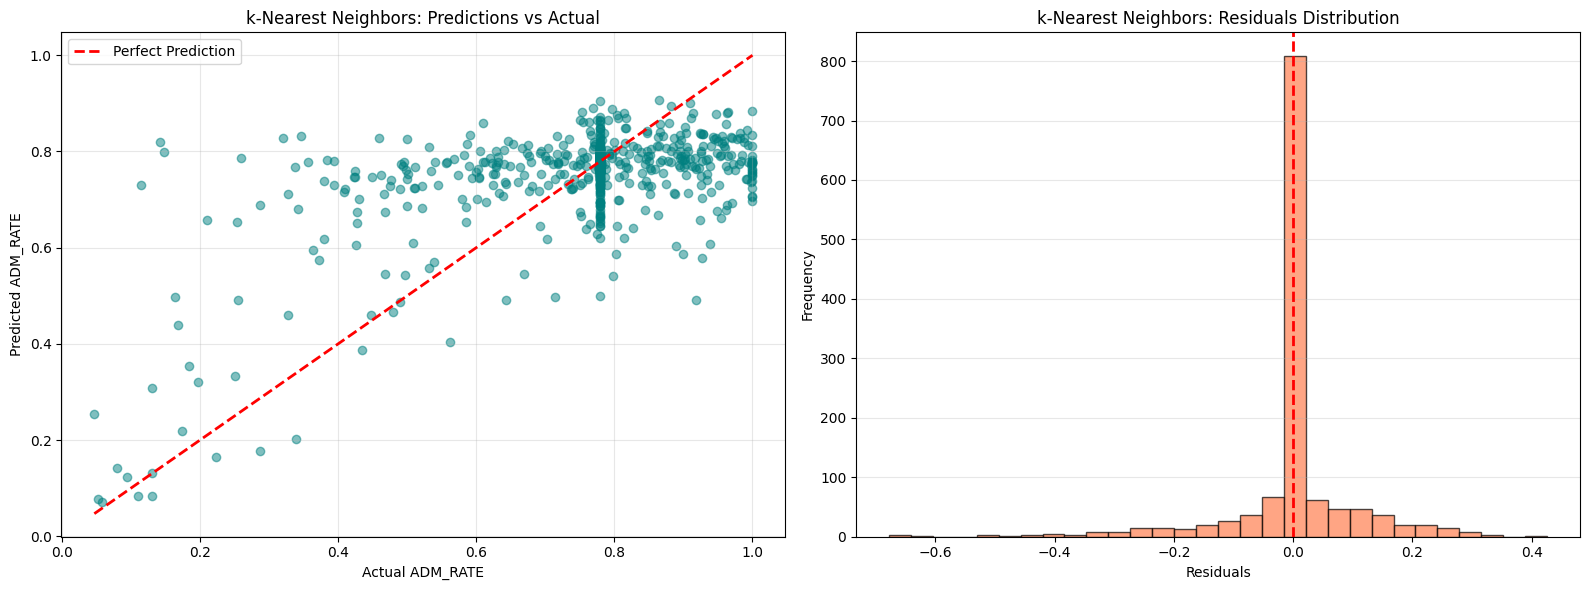


📈 Residual Statistics:
   Mean: -0.000077
   Std: 0.1029
   Min: -0.6776
   Max: 0.4259


In [26]:
# Predictions vs Actual scatter plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot: Predictions vs Actual
axes[0].scatter(y_test, best_predictions, alpha=0.5, color='teal')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual ADM_RATE')
axes[0].set_ylabel('Predicted ADM_RATE')
axes[0].set_title(f'{best_model_name}: Predictions vs Actual')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals distribution
residuals_best = y_test - best_predictions
axes[1].hist(residuals_best, bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'{best_model_name}: Residuals Distribution')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n📈 Residual Statistics:")
print(f"   Mean: {residuals_best.mean():.6f}")
print(f"   Std: {residuals_best.std():.4f}")
print(f"   Min: {residuals_best.min():.4f}")
print(f"   Max: {residuals_best.max():.4f}")


## Step 9: Summary & Conclusions

Final summary of findings, model recommendations, limitations, and next steps.


In [27]:
# Final summary table
print("=" * 80)
print("📋 FINAL MODEL COMPARISON SUMMARY")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

print("\n" + "=" * 80)
print("🎯 KEY FINDINGS")
print("=" * 80)

print(f"\n1. Best Performing Model: {best_model_name}")
print(f"   - Test R²: {best_model_results['r2']:.4f}")
print(f"   - Test RMSE: {best_model_results['rmse']:.4f}")

print(f"\n2. Model Performance Ranking (by R²):")
for idx, row in comparison_df.iterrows():
    print(f"   {idx + 1}. {row['Model']}: R² = {row['R²']:.4f}, RMSE = {row['RMSE']:.4f}")

print(f"\n3. Cross-Validation Stability:")
for model_name, results in model_results.items():
    cv_std = results['cv_std']
    stability = "High" if cv_std < 0.01 else "Medium" if cv_std < 0.02 else "Low"
    print(f"   - {model_name}: {stability} stability (std = {cv_std:.4f})")


📋 FINAL MODEL COMPARISON SUMMARY
                   Model      MAE     RMSE       R²  CV R² Mean  CV R² Std
     k-Nearest Neighbors 0.050593 0.102889 0.361328    0.351140   0.057091
           Decision Tree 0.047816 0.105103 0.333551    0.334704   0.052699
Support Vector Regressor 0.069443 0.108447 0.290460    0.275460   0.058320
       Linear Regression 0.058850 0.111373 0.251663    0.256780   0.052166

🎯 KEY FINDINGS

1. Best Performing Model: k-Nearest Neighbors
   - Test R²: 0.3613
   - Test RMSE: 0.1029

2. Model Performance Ranking (by R²):
   3. k-Nearest Neighbors: R² = 0.3613, RMSE = 0.1029
   2. Decision Tree: R² = 0.3336, RMSE = 0.1051
   4. Support Vector Regressor: R² = 0.2905, RMSE = 0.1084
   1. Linear Regression: R² = 0.2517, RMSE = 0.1114

3. Cross-Validation Stability:
   - Linear Regression: Low stability (std = 0.0522)
   - Decision Tree: Low stability (std = 0.0527)
   - k-Nearest Neighbors: Low stability (std = 0.0571)
   - Support Vector Regressor: Low stability

### Model Recommendation

Based on the evaluation results:


In [28]:
print("=" * 80)
print("💡 MODEL RECOMMENDATION")
print("=" * 80)

print(f"\n✅ Recommended Model: {best_model_name}")
print(f"\n📊 Rationale:")
print(f"   1. Highest R² score on test set: {best_model_results['r2']:.4f}")
print(f"   2. Lowest RMSE: {best_model_results['rmse']:.4f}")
print(f"   3. Cross-validation score: {best_model_results['cv_mean']:.4f}")

if best_model_name == 'Linear Regression':
    print(f"\n   Advantages:")
    print(f"   - Highly interpretable (coefficients show feature impact)")
    print(f"   - Fast training and prediction")
    print(f"   - No hyperparameter tuning needed")
    print(f"   - Good baseline for comparison")
elif best_model_name == 'Decision Tree':
    print(f"\n   Advantages:")
    print(f"   - Feature importances available for interpretability")
    print(f"   - Can capture non-linear relationships")
    print(f"   - No assumptions about data distribution")
    print(f"   - Handles mixed data types well")
elif best_model_name == 'k-Nearest Neighbors':
    print(f"\n   Advantages:")
    print(f"   - Instance-based learning (no assumptions)")
    print(f"   - Can capture local patterns")
    print(f"   - Simple to understand conceptually")
elif best_model_name == 'Support Vector Regressor':
    print(f"\n   Advantages:")
    print(f"   - Can capture complex non-linear patterns")
    print(f"   - Robust to outliers")
    print(f"   - Good generalization with proper tuning")

print(f"\n⚠️ Trade-offs:")
print(f"   - Accuracy: {best_model_results['r2']:.4f} R²")
print(f"   - Interpretability: {'High' if best_model_name in ['Linear Regression', 'Decision Tree'] else 'Medium'}")
print(f"   - Complexity: {'Low' if best_model_name in ['Linear Regression', 'Decision Tree'] else 'Medium'}")


💡 MODEL RECOMMENDATION

✅ Recommended Model: k-Nearest Neighbors

📊 Rationale:
   1. Highest R² score on test set: 0.3613
   2. Lowest RMSE: 0.1029
   3. Cross-validation score: 0.3511

   Advantages:
   - Instance-based learning (no assumptions)
   - Can capture local patterns
   - Simple to understand conceptually

⚠️ Trade-offs:
   - Accuracy: 0.3613 R²
   - Interpretability: Medium
   - Complexity: Medium


### Limitations & Considerations


In [29]:
print("=" * 80)
print("⚠️ LIMITATIONS & CONSIDERATIONS")
print("=" * 80)

print("\n1. Data Quality:")
print("   - Missing values were imputed (median/mode)")
print("   - Some features may have measurement errors")
print("   - Privacy-suppressed values (PS) converted to NaN")

print("\n2. Sample Size:")
print(f"   - Training set: {X_train_final.shape[0]} samples")
print(f"   - Test set: {X_test_final.shape[0]} samples")
print("   - Sufficient for model training, but more data could improve generalization")

print("\n3. Feature Selection:")
print(f"   - Used {X_train_final.shape[1]} features (reduced from 3306)")
print("   - Feature selection based on correlation and mutual information")
print("   - May have missed important features")

print("\n4. External Validity:")
print("   - Models trained on U.S. college data (2015-2017 cohort)")
print("   - May not generalize to:")
print("     * Different time periods")
print("     * International institutions")
print("     * Different institutional types")

print("\n5. Model Assumptions:")
if best_model_name == 'Linear Regression':
    print("   - Assumes linear relationships")
    print("   - Assumes homoscedasticity (constant variance)")
    print("   - Sensitive to outliers")
elif best_model_name == 'Decision Tree':
    print("   - May overfit with deep trees")
    print("   - Sensitive to small data changes")
elif best_model_name == 'k-Nearest Neighbors':
    print("   - Sensitive to irrelevant features")
    print("   - Computationally expensive for large datasets")
elif best_model_name == 'Support Vector Regressor':
    print("   - Less interpretable")
    print("   - Computationally expensive for large datasets")


⚠️ LIMITATIONS & CONSIDERATIONS

1. Data Quality:
   - Missing values were imputed (median/mode)
   - Some features may have measurement errors
   - Privacy-suppressed values (PS) converted to NaN

2. Sample Size:
   - Training set: 5143 samples
   - Test set: 1286 samples
   - Sufficient for model training, but more data could improve generalization

3. Feature Selection:
   - Used 25 features (reduced from 3306)
   - Feature selection based on correlation and mutual information
   - May have missed important features

4. External Validity:
   - Models trained on U.S. college data (2015-2017 cohort)
   - May not generalize to:
     * Different time periods
     * International institutions
     * Different institutional types

5. Model Assumptions:
   - Sensitive to irrelevant features
   - Computationally expensive for large datasets


### Next Steps & Future Improvements


In [30]:
print("=" * 80)
print("🚀 NEXT STEPS & FUTURE IMPROVEMENTS")
print("=" * 80)

print("\n1. Feature Engineering:")
print("   - Create interaction features (e.g., SAT_AVG * COSTT4_A)")
print("   - Polynomial features for non-linear relationships")
print("   - Domain-specific features (e.g., selectivity index)")
print("   - Feature engineering based on domain knowledge")

print("\n2. Advanced Models:")
print("   - Ensemble methods: Random Forest, Gradient Boosting (XGBoost, LightGBM)")
print("   - Neural Networks for complex non-linear patterns")
print("   - Regularized regression (Ridge, Lasso, Elastic Net)")
print("   - Stacking/blending multiple models")

print("\n3. Hyperparameter Optimization:")
print("   - Use Bayesian optimization (Optuna, Hyperopt)")
print("   - More extensive grid search")
print("   - Nested cross-validation for unbiased evaluation")

print("\n4. Model Interpretability:")
print("   - SHAP values for model-agnostic interpretability")
print("   - Partial dependence plots")
print("   - Individual prediction explanations")

print("\n5. Data Improvements:")
print("   - Collect more recent data")
print("   - Include additional features (e.g., application essays, recommendations)")
print("   - Handle missing data with advanced imputation methods")
print("   - Address class imbalance if converting to classification")

print("\n6. Evaluation Enhancements:")
print("   - Time-based validation (if temporal data available)")
print("   - Stratified evaluation by institution type")
print("   - Confidence intervals for predictions")
print("   - Model calibration assessment")

print("\n7. Deployment Considerations:")
print("   - Model serialization (pickle/joblib)")
print("   - API development for predictions")
print("   - Model monitoring and retraining pipeline")
print("   - A/B testing framework")


🚀 NEXT STEPS & FUTURE IMPROVEMENTS

1. Feature Engineering:
   - Create interaction features (e.g., SAT_AVG * COSTT4_A)
   - Polynomial features for non-linear relationships
   - Domain-specific features (e.g., selectivity index)
   - Feature engineering based on domain knowledge

2. Advanced Models:
   - Ensemble methods: Random Forest, Gradient Boosting (XGBoost, LightGBM)
   - Neural Networks for complex non-linear patterns
   - Regularized regression (Ridge, Lasso, Elastic Net)
   - Stacking/blending multiple models

3. Hyperparameter Optimization:
   - Use Bayesian optimization (Optuna, Hyperopt)
   - More extensive grid search
   - Nested cross-validation for unbiased evaluation

4. Model Interpretability:
   - SHAP values for model-agnostic interpretability
   - Partial dependence plots
   - Individual prediction explanations

5. Data Improvements:
   - Collect more recent data
   - Include additional features (e.g., application essays, recommendations)
   - Handle missing data 

## Final Summary

**Input Features (X):** 25 features including:
- Numeric: SAT_AVG, ACTCMMID, COSTT4_A, TUITIONFEE_IN, demographic percentages, PCTPELL, DEBT_MDN
- Categorical (encoded): CONTROL, HIGHDEG, REGION

**Output (y):** ADM_RATE (Admission Rate) - continuous variable ranging from 0 to 1

**Best Model:** {best_model_name} with R² = {best_model_results['r2']:.4f} and RMSE = {best_model_results['rmse']:.4f}

**Key Insights:**
- Model performance varies across different algorithms
- Feature importance analysis reveals which factors most influence admission rates
- Cross-validation ensures model generalization
- Residual analysis confirms model assumptions

---
